In [130]:
import pandas as pd
import torch
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import lightning.pytorch as pl
import os
import numpy as np

pl.seed_everything(42, workers=True)

Seed set to 42


42

In [96]:
LOG_DIR = "/app/Modeling/logs"

In [2]:
data_dir = "/app/bucket/data/processed_data"
filedir = os.path.join(data_dir, "prep_D_data.csv")
data_df = pd.read_csv(filedir)
data_df['ds'] = pd.to_datetime(data_df['ds'], format='%Y-%m-%d')
data_df.set_index('ds', inplace=True)
data_df = data_df.sort_index()

data_df['time_idx'] = range(len(data_df))
data_df['group'] = 'SPY'
data_df['day_of_week'] = data_df.index.dayofweek.astype(str)
data_df['week_of_year'] = data_df.index.isocalendar().week.astype(str)
print(data_df.shape)
data_df.head()

(3873, 18)


,spy_close,SMA_60,SMA_120,BBL_20,BBM_20,BBU_20,BBB_20,BBP_20,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,spy_volume_lag_1D,CLI_lag_1MS,time_idx,group,day_of_week,week_of_year
ds,,,,,,,,,,,,,,,,,,
2010-06-24,107.42,114.281667,113.377000,105.188016,109.3740,113.559984,7.654440,0.266602,-0.703357,0.184935,-0.888292,40.495411,254639900.0,99.71648,0,SPY,3,25
2010-06-25,107.87,114.129500,113.331500,105.045443,109.2295,113.413557,7.661039,0.337538,-0.800797,0.069997,-0.870793,42.094856,268523600.0,99.71648,1,SPY,4,25
2010-06-28,107.53,113.958333,113.280667,104.886076,109.1375,113.388924,7.790950,0.310946,-0.895135,-0.019473,-0.875662,41.193901,238726500.0,99.71648,2,SPY,0,26
2010-06-29,104.21,113.715833,113.201500,104.225322,108.9715,113.717678,8.710860,-0.001614,-1.223688,-0.278421,-0.945267,33.625754,169218600.0,99.71648,3,SPY,1,26
2010-06-30,103.22,113.452167,113.110083,103.270937,108.6160,113.961063,9.842129,-0.004765,-1.546132,-0.480692,-1.065440,31.752420,373649500.0,99.71648,4,SPY,2,26


In [48]:
data_df.columns

Index(['spy_close', 'SMA_60', 'SMA_120', 'BBL_20', 'BBM_20', 'BBU_20',
       'BBB_20', 'BBP_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
       'RSI_14', 'spy_volume_lag_1D', 'CLI_lag_1MS', 'time_idx', 'group',
       'day_of_week', 'week_of_year'],
      dtype='object')

In [ ]:
# Split dataset
train_cut_off = data_df['time_idx'].max() - 480
print(f"Train cut off: {train_cut_off}")
val_cut_off = data_df['time_idx'].max() - 240
print(f"Validation cut off: {val_cut_off}")

train_dataset = TimeSeriesDataSet(
    data_df[lambda x: x.time_idx <= train_cut_off],
    time_idx="time_idx",
    target="spy_close",
    group_ids=["group"],
    min_encoder_length=20//2,
    max_encoder_length=20,
    max_prediction_length=10, 
    
    # [변수 타입 정의]
    time_varying_known_categoricals=["day_of_week", "week_of_year", "group"],
    time_varying_known_reals=["time_idx"], 
    time_varying_unknown_reals=['spy_close', 'SMA_60', 'SMA_120',
       'BBB_20', 'BBP_20', 'MACDh_12_26_9',
       'RSI_14', 'spy_volume_lag_1D', 'CLI_lag_1MS'], # 예측 대상은 모르는 변수
    
    # [정규화]
    target_normalizer=GroupNormalizer(groups=["group"], transformation=None),
    # target_normalizer=GroupNormalizer(groups=["group"], transformation="softplus"),

    # [기타 설정]
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset,
    data_df[lambda x: x.time_idx <= val_cut_off],
    min_prediction_idx=train_dataset.index.time.max() + 1,
    stop_randomization=True)

test_dataset = TimeSeriesDataSet.from_dataset(train_dataset,
    data_df,
    min_prediction_idx=val_dataset.index.time.max() + 1,
    stop_randomization=True)

Train cut off: 3392
Validation cut off: 3632


In [218]:
# dataloaders
batch_size = 64
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [219]:
# batch = next(iter(val_dataloader))
# print(batch[0].keys())
# batch[0]

In [220]:
pl.seed_everything(42)
# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30, # coment in for training, running valiation every 30 batches
    callbacks=[lr_logger, early_stop_callback],
    deterministic=True,
)

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [221]:
# 1. TFT 모델 정의
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    # learning_rate=0.03, #0.001
    hidden_size=8, # 16
    attention_head_size=1, # 4
    dropout=0.3, # 0.1
    # hidden_continuous_size=16, # hidden_size 이하
    # output_size=7, # 7
    loss=QuantileLoss(),
    # log_interval=2,
    reduce_on_plateau_patience=4, # 1000
    optimizer="adam",
)

/usr/local/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [222]:
# res = trainer.tuner.lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     min_lr=1e-5,
#     max_lr=10,
# )
# print(f"Suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [223]:
# 2. 학습 실행
trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 445    | train
3  | prescalers                         | ModuleDict                      | 224    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.9 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.0 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 304    | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 32: 100%|██████████| 30/30 [00:04<00:00,  6.02it/s, v_num=46, train_loss_step=3.070, val_loss=61.00, train_loss_epoch=3.380]


In [224]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Best model path: /app/Modeling/lightning_logs/version_46/checkpoints/epoch=32-step=990.ckpt


/usr/local/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [225]:
# Calculate MAE on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
mae = (actuals - predictions).abs().mean()
print(f"MAE on validation set: {mae}")

MAE on validation set: 80.8293685913086


In [226]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

/usr/local/lib/python3.11/site-packages/pytorch_forecasting/models/base/_base_model.py:125: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 10, 1, 20]). Returning list instead of torch.Tensor.
  warnings.warn(


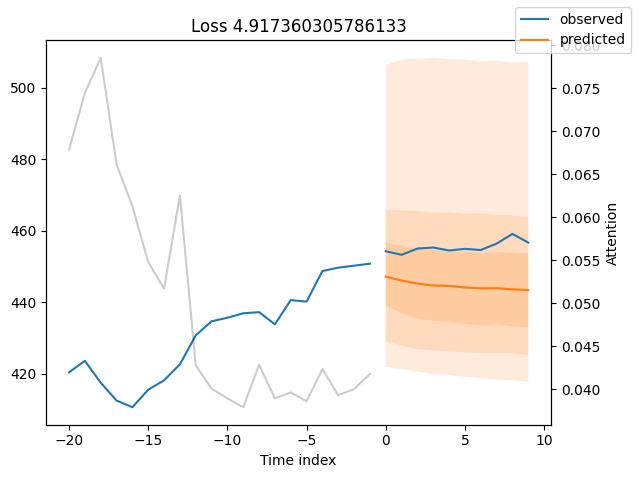

In [227]:
fig = best_tft.plot_prediction(raw_predictions.x,
    raw_predictions.output,
    idx=0,
    add_loss_to_title=True)
plt.show()

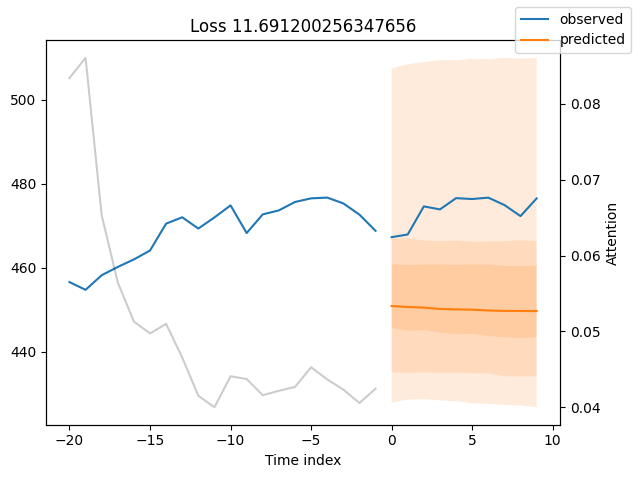

In [228]:
fig = best_tft.plot_prediction(raw_predictions.x,
    raw_predictions.output,
    idx=30,
    add_loss_to_title=True)
plt.show()

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x550 with 1 Axes>,
 'decoder_variables': <Figure size 700x325 with 1 Axes>}

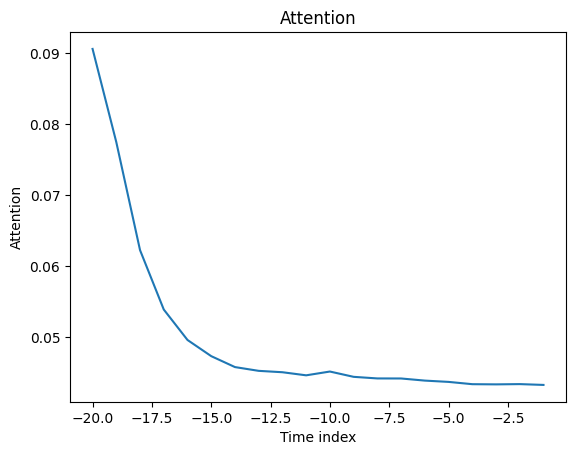

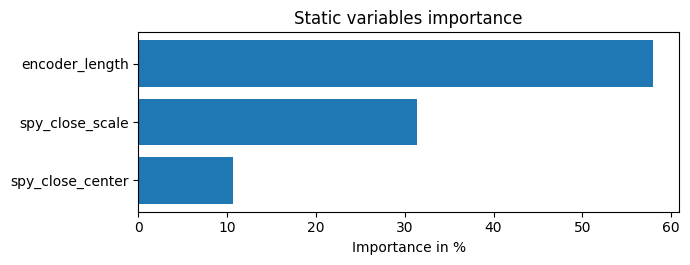

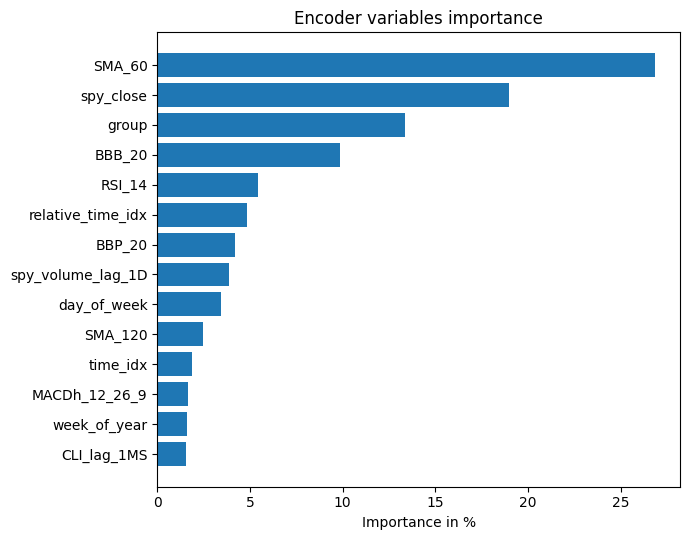

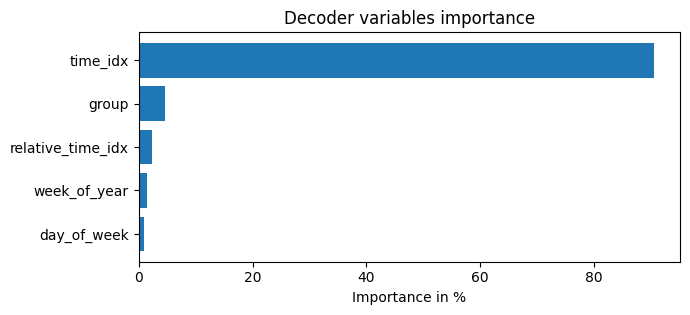

In [229]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)